### Convolutional Neural Network to predict a future GHI on image inputs (Part 1 training)

This code shows a method to train a CNN with GOES images from the CMI product on band 2, to predict the GHI in a future time. To do this the training is done with real GHI data shifted by the desired amount to be predicted into the future, this time however, should not be too long (less than 4 hours).

Although this example only contaings band 2, the code was designed to run on RGB images on 3 channel inputs. To do this some parts of the code need to be modified or uncommented accordingly. 

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xarray as xr
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Flatten, Conv2D, TimeDistributed
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin

The images are lagged by the amount into the future that wants to be predicted. 

In [37]:
# Define the lag time in minutes

t_lag = 120

# t_fix should be set to 0 in most cases (unless the base data needs a shift in time)
t_fix = 0

Define the path of the images to create a list of the corresponding names and dates. The file names should always follow the  
[ABI file naming conventions](https://cimss.ssec.wisc.edu/goes/ABI_File_Naming_Conventions.pdf).

In [38]:
# Define paths

direccion = 'D:/Downloads/comprimidos/'
carpeta_imagenes = 'GOES_CMIPF_sliced_resized'

image_folder = os.path.join(direccion, carpeta_imagenes)
image_files = sorted([os.path.join(image_folder, i) for i in os.listdir(image_folder) if i.endswith('.nc')])

imagenes_filtradas = []  # Store the filtered image paths and their timestamps

# Process only images between 5:00 a.m. and 18:30
for nombre_imagen in os.listdir(image_folder):
    if nombre_imagen.startswith('OR_ABI-L2-CMIPF-M6C02_G16_'):
        fecha_hora_str = nombre_imagen.split('_')[3][1:15] 
        year = fecha_hora_str[:4]
        day_of_year = fecha_hora_str[4:7]
        hour = fecha_hora_str[7:9]
        minute = fecha_hora_str[9:11]
        
        # Convert to datetime object
        fecha_hora = datetime.strptime(f"{year} {day_of_year} {hour} {minute}", "%Y %j %H %M") - timedelta(hours=5)
        hora = fecha_hora.time()
        # hora_inicio = datetime.strptime('05:00', '%H:%M').time()
        # hora_fin = datetime.strptime('18:30', '%H:%M').time()
        hora_inicio = datetime.strptime('00:01', '%H:%M').time()
        hora_fin = datetime.strptime('23:59', '%H:%M').time()
        
        # Filter images by time
        if hora >= hora_inicio and hora <= hora_fin:
            ruta_completa = os.path.join(image_folder, nombre_imagen)
            imagenes_filtradas.append((ruta_completa, fecha_hora))

# No need to copy the images, just process them directly
print(f"Total number of filtered image files: {len(imagenes_filtradas)}")

# imagenes_filtradas

Número total de archivos de imagen filtrados: 3847


In [39]:
# Create a dictionary of the nc files in the folder (required for matching RGB images of different bands)
# Adjust the names and values according to the desired band to work with.
imagenes_filtradas_rgb = {}
missing_dates = []
for imagen in imagenes_filtradas:
    date_loc = imagen[0].split('_')[-3][1:12]
    def get_nc_from_band(band):
        if band < 10:
            band_str = 'M6C0' + str(band)
        else:
            band_str = 'M6C' + str(band)
        ncs_file = [f'{image_folder}/{i}'
            for i in os.listdir(image_folder)
            if i.endswith('.nc')
            and band_str in i
            and date_loc in i
            ]
        return ncs_file
    ncs_B02 = imagen[0]
    datetime_obj = imagen[1]
    
    imagenes_filtradas_rgb[date_loc] = {
        'B02': ncs_B02,
        'Datetime': datetime_obj
        }


#### Run this code instead of the above one to use RGB images for bands 2, 5 and 13.
# imagenes_filtradas_rgb = {}
# missing_dates = []
# for imagen in imagenes_filtradas:
#     date_loc = imagen[0].split('_')[-3][1:12]
#     def get_nc_from_band(band):
#         if band < 10:
#             band_str = 'M6C0' + str(band)
#         else:
#             band_str = 'M6C' + str(band)
#         ncs_file = [f'{image_folder}/{i}' 
#             for i in os.listdir(image_folder) 
#             if i.endswith('.nc') 
#             and band_str in i
#             and date_loc in i
#             ]
#         return ncs_file
#     ncs_B05 = imagen[0]
#     ncs_B02 = get_nc_from_band(2)
#     ncs_B13 = get_nc_from_band(13)
#     datetime_obj = imagen[1]

#     if ncs_B13 and ncs_B02:
#         imagenes_filtradas_rgb[date_loc] = {
#             'B02': ncs_B02[0],
#             'B05': ncs_B05,
#             'B13': ncs_B13[0],
#             'Datetime': datetime_obj
#         }
#     else:
#         missing_dates.append(datetime_obj)

In [40]:
lista_de_fechas = [entry['Datetime'] for entry in imagenes_filtradas_rgb.values()]
# lista_de_fechas

These were the global max and min values from the trained dataset from Oct-2023 to Aug-2024, for the bands 2, 5 and 13:

In [41]:
global_max_B02= 1.2507925033569336
global_min_B02= 0.00031746001332066953
global_max_B05= 1.2688876390457153
global_min_B05= 0.0
global_max_B13= 319.7626953125
global_min_B13= 184.5653839111328

This code generates the RGB images used for training. In this example only band 2 is being used, however, uncommenting and adjusting the code will make it work for different single bands or all 3 in a mapping to each RGB channel. 

In [42]:
def make_rgb_images(image_group, target_size=(40, 40)):

    ds_B02 = xr.open_dataset(image_group['B02'])
    image_B02 = ds_B02['CMI'].values
    max_B02 = max(global_max_B02, np.max(image_B02))
    min_B02 = min(global_min_B02, np.min(image_B02))
    normalized_B02  = (image_B02 - min_B02) / (max_B02 - min_B02)

    # ds_B05 = xr.open_dataset(image_group['B05'])
    # image_B05 = ds_B05['CMI'].values
    # max_B05 = max(global_max_B05, np.max(image_B05))
    # min_B05 = min(global_min_B05, np.min(image_B05))
    # normalized_B05  = (image_B05 - min_B05) / (max_B05 - min_B05)

    # ds_B13 = xr.open_dataset(image_group['B13'])
    # image_B13 = ds_B13['CMI'].values
    # max_B13 = max(global_max_B13, np.max(image_B13))
    # min_B13 = min(global_min_B13, np.min(image_B13))
    # normalized_B13  = (image_B13 - min_B13) / (max_B13 - min_B13)

    ##### Real RGB image with 3 channel data
    # rgb_image = np.stack([normalized_B02, normalized_B05, normalized_B13], axis=-1)

    ##### Fake RGB image with repeated channel data
    rgb_image = np.stack([normalized_B02, normalized_B02, normalized_B02], axis=-1)
    image_final = cv2.resize(rgb_image, target_size)

    return image_final

# image_group = imagenes_filtradas_rgb['20232891800']
# image_final = make_rgb_images(image_group, target_size=(300, 300))
# plt.imshow(image_final)
# plt.colorbar()

The following code loads the CSV file with all the GHI data. The time is Adjusted to UTC-5 and then is lagged to generate the desired training dataset.

In [43]:
# Load and process the data
df = pd.read_csv('Datos_completos_comma.csv')
df['t'] = pd.to_datetime(df['t'], utc=True)
df.set_index('t', inplace=True)
df.index = df.index - pd.DateOffset(hours=5)


lista_de_fechas_utc = pd.to_datetime(lista_de_fechas).tz_localize('UTC', nonexistent='NaT', ambiguous='NaT')

matching_dates = lista_de_fechas_utc - pd.Timedelta(minutes=t_fix) 
df_orig = df[df.index.isin(matching_dates)]
df_orig.reset_index(inplace=True)
missing_data_orig = df_orig[df_orig['GHI'].isna()]['t'] + pd.Timedelta(minutes=t_fix)

lagged_dates = lista_de_fechas_utc - pd.Timedelta(minutes=t_lag)
df_lag = df[df.index.isin(lagged_dates)]
df_lag.reset_index(inplace=True)
missing_data_lag = df_lag[df_lag['GHI'].isna()]['t'] + pd.Timedelta(minutes=t_lag)

combined_missing_data = pd.concat([missing_data_lag, missing_data_orig]).drop_duplicates().sort_values()
filtered_lista_de_fechas_utc = lista_de_fechas_utc[~lista_de_fechas_utc.isin(combined_missing_data)]

lagged_dates = filtered_lista_de_fechas_utc - pd.Timedelta(minutes=t_lag)
matching_dates = filtered_lista_de_fechas_utc - pd.Timedelta(minutes=t_fix)

df_orig = df[df.index.isin(matching_dates)]
df_orig.reset_index(inplace=True)

df_lag = df[df.index.isin(lagged_dates)]
df_lag.reset_index(inplace=True)

In [44]:
# Scale the GHI variable
scaler = MinMaxScaler()
# df_lag['GHI'] = scaler.fit_transform(df_lag[['GHI']])
# df_orig['GHI'] = scaler.fit_transform(df_orig[['GHI']])
df_lag.loc[:, 'GHI'] = scaler.fit_transform(df_lag[['GHI']])
df_orig.loc[:, 'GHI'] = scaler.fit_transform(df_orig[['GHI']])

In [ ]:
df_orig['hour_fraction'] = df_orig['t'].dt.hour + df_orig['t'].dt.minute / 60
df_lag['hour_fraction'] = df_lag['t'].dt.hour + df_lag['t'].dt.minute / 60

# Compute sine and cosine of the time in fractional hours
df_orig['DoY Sin'] = np.sin(df_orig['hour_fraction'] * 2 * np.pi / 24)
df_orig['DoY Cos'] = np.cos(df_orig['hour_fraction'] * 2 * np.pi / 24)

df_lag['DoY Sin'] = np.sin(df_lag['hour_fraction'] * 2 * np.pi / 24)
df_lag['DoY Cos'] = np.cos(df_lag['hour_fraction'] * 2 * np.pi / 24)

# Select required columns
columnas = ['t', 'GHI', 'DoY Sin', 'DoY Cos']
df_lag = df_lag[columnas]
df_orig = df_orig[columnas]

# Create the numeric variables and the output variable for the model
numericas = ['GHI','DoY Sin','DoY Cos']
valores_numericos = df_orig[numericas].values
salida = ['GHI']
y = df_lag[salida].values

In [46]:
tiempo = df_orig['t'].dt.hour + df_orig['t'].dt.minute / 60
tiempo.values.shape

(3724,)

In [47]:
# Convert filtered_lista_de_fechas_utc to a set for faster lookup
filtered_set = set(filtered_lista_de_fechas_utc)

# Create a new dictionary after filtering based on 'Datetime'
filtered_imagenes_filtradas_rgb = {
    key: value for key, value in imagenes_filtradas_rgb.items()
    if pd.Timestamp(value['Datetime']).tz_localize('UTC') in filtered_set
}

# Print or use the filtered dictionary
len(filtered_imagenes_filtradas_rgb)


3724

In [48]:
# Generate the RGB images with the make_rgb_images function defined in a previous step
import pytz

image_tensors = []

for n_element in filtered_imagenes_filtradas_rgb:

    image_tensor = make_rgb_images(filtered_imagenes_filtradas_rgb[n_element], target_size=(64,64))
    image_tensors.append(image_tensor)

tensor_images = np.array(image_tensors)
print(f"Formato de tensor_images: {tensor_images.shape}")

Formato de tensor_images: (3724, 64, 64, 3)


Plot all the data, the final graph should show the curve of the day and the sine and cosine of the day, for the start and end times previously defined (by defaul it should be daytime)

Text(0.5, 0, 'tiempo (h)')

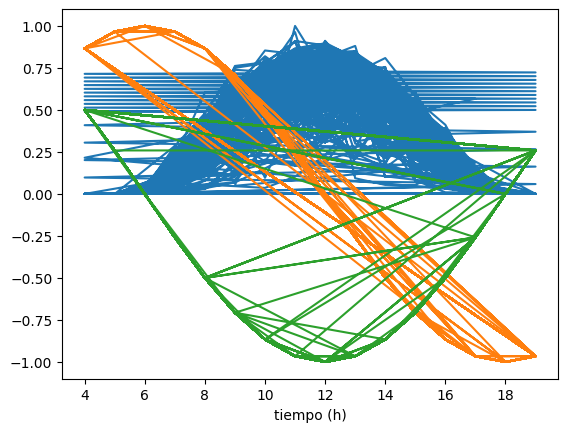

In [49]:
plt.plot(tiempo, valores_numericos)
plt.xlabel('tiempo (h)')

# plt.plot(valores_numericos)


7.0


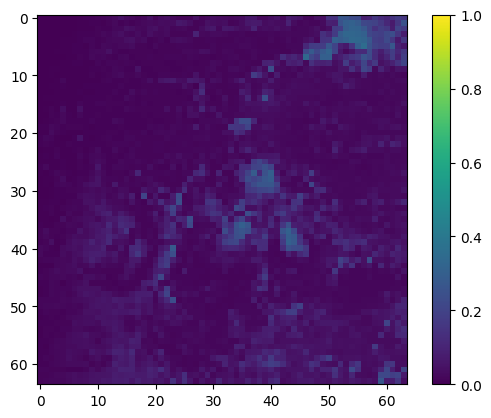

In [50]:
# display image 100 of the dataset to verify it is being correctly handled
ind = 100
print(tiempo.values[ind])
plt.imshow(tensor_images[ind,:,:,1], vmin=0, vmax = 1)
plt.colorbar()

The final tensor, can be saved to avoid repeating all the processing from above. If thats the case uncomment the following cells:

In [51]:
# np.save('tensor_images_64_lag120_B02.npy', tensor_images)

In [52]:
# tensor_images = np.load('tensor_images_64_lag120_B02.npy')

Example plor for a selected range. Both graphs should be the same displaced by the lagging amount defined at the begining in `t_lag`

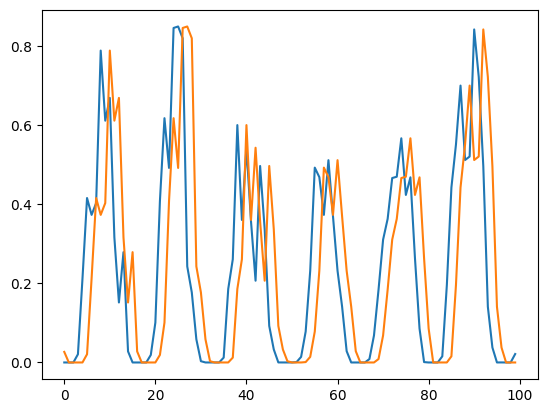

In [53]:
plt.plot(valores_numericos[0:100,0])
plt.plot(y[0:100])

Create the variables for training and validation with randomness. By default it is set to 80% training and 20% validation. The size across the first dimension of all three training data must be the same. 

In [54]:
from sklearn.model_selection import train_test_split

# Split data (80% training, 20% testing)
X_train_img, X_val_img, X_train_num, X_val_num, y_train, y_val = train_test_split(
    tensor_images, valores_numericos, y, test_size=0.2, random_state=42)

# Confirm shapes
print(f"Training images shape: {X_train_img.shape}")
print(f"Training numerical data shape: {X_train_num.shape}")
print(f"Training GHI shape: {y_train.shape}")


Training images shape: (2979, 64, 64, 3)
Training numerical data shape: (2979, 3)
Training GHI shape: (2979, 1)


Create a CNN model that combines both image and numerical inputs to predict GHI. The images have been downscaled to a resoultion of 64x64, so it should match with the shape below. These RGB images are processed through a series of convolutional and pooling layers to extract visual features, while numerical data is processed through fully connected layers. The outputs of both branches are concatenated and passed through additional dense layers to predict the GHI. The model is compiled using the Adam optimizer and Mean Squared Error (MSE) as the loss function, suitable for regression tasks.

The 64x64 input size can be altered, but should also be done in the respective code blocks above so it matches the model. 

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate

# Image input
image_input = Input(shape=(64, 64, 3), name='image_input')

# Convolutional layers for image data
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Numerical input
numerical_input = Input(shape=(valores_numericos.shape[1],), name='numerical_input')
y = Dense(64, activation='relu')(numerical_input)

# Concatenate the outputs
combined = concatenate([x, y])

# Fully connected layers
z = Dense(64, activation='relu')(combined)
z = Dense(1, activation='linear')(z)  # Output: predicted GHI

# Create the model
model = Model(inputs=[image_input, numerical_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 31, 31,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 6, 6, 128) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4608)      │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │        256 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4672)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │    299,072 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 392,641 (1.50 MB)

 Trainable params: 392,641 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Train the model with both image and numerical data
history = model.fit(
    [X_train_img, X_train_num], y_train,
    validation_data=([X_val_img, X_val_num], y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20


d:\Downloads\Test_goes\GOES_env\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'numerical_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0530 - val_loss: 0.0170
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0147 - val_loss: 0.0158
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0145 - val_loss: 0.0153
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0124 - val_loss: 0.0136
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0122 - val_loss: 0.0139
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0127 - val_loss: 0.0134
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0126 - val_loss: 0.0136
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0119 - val_loss: 0.0137
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0123 - val_l

In [57]:
# Evaluate the model
test_loss = model.evaluate([X_val_img, X_val_num], y_val)
print(f"Test Loss (MSE): {test_loss}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144
Test Loss (MSE): 0.013206539675593376


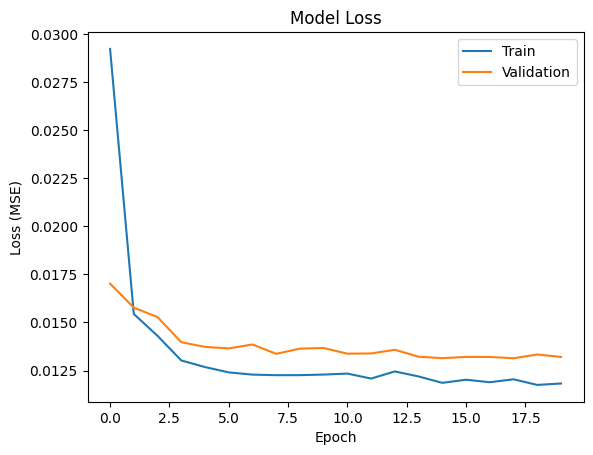

In [58]:
# Plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [59]:
# Save the model to as a .h5 file for inference
model.save('model.h5')